In [1]:
import jax
jax.config.update('jax_default_device',jax.devices()[-1])
import equinox as eqx
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from jax import grad, vmap
import optax
from diffrax import (
    diffeqsolve, ODETerm, Dopri5, ControlTerm, 
    Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, Heun,
    WeaklyDiagonalControlTerm,
)
from tqdm.auto import tqdm


In [2]:
from stochastic_interpolant.neural_network import NeuralNetwork
from stochastic_interpolant.dataloaders import (
    DatasetSampler,GaussianReferenceSampler,IndependenceCouplingSampler,build_trainloader,testloader_factory)
from stochastic_interpolant.loss_functions import get_trig_interpolants,root_prod_gamma,root_prod_gammadot,get_loss_functions
from stochastic_interpolant.data_generators import inf_train_gen
from stochastic_interpolant.model_training import train_model

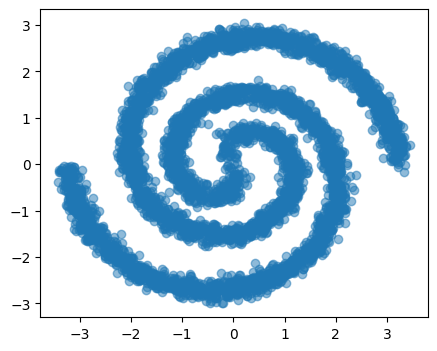

In [3]:
num_target = 5000
target_samples = inf_train_gen('2spirals',rng = 50,batch_size = num_target)
reference_samples = jax.random.normal(jax.random.PRNGKey(13334),(5000,2))
plt.figure(figsize=(5,4))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha=0.5)
plt.show()

In [4]:
I,It = get_trig_interpolants()
gamma = root_prod_gamma
gammadot = root_prod_gammadot
loss_b,loss_denoise = get_loss_functions(I,It,gamma,gammadot)

b_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(21239)
)
eta_model = NeuralNetwork(
    input_size = 3,
    output_size=2,
    layer_sizes = [256,256,256], 
    key = jax.random.PRNGKey(30238)
)

data_coupling_sampler = IndependenceCouplingSampler(
    GaussianReferenceSampler((2,)),
    DatasetSampler(target_samples)
    )
batch_size = 1024

train_loader = build_trainloader(batch_size,jax.random.PRNGKey(124),data_coupling_sampler)
test_factory = testloader_factory(1024,jax.random.PRNGKey(32498130),data_coupling_sampler)

In [5]:
b_optim = optax.adamw(1e-3)

b_model,b_loss_history = train_model(
  model = b_model,
  optim = b_optim,
  steps = 20000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_b,
  print_every = 5000,
  num_testloader_batches = 100,
)

eta_optim = optax.adamw(1e-3)

eta_model,eta_loss_history = train_model(
  model = eta_model,
  optim = eta_optim,
  steps = 20000,
  train_loader = train_loader,
  testloader_factory = test_factory,
  loss_fun = loss_denoise,
  print_every = 5000,
  num_testloader_batches = 100,
)


  0%|          | 0/20000 [00:00<?, ?it/s]

step=0 | train_loss=0.00428874 | test_loss= -0.6169966
step=5000 | train_loss=-2.4754105 | test_loss= -1.7532114
step=10000 | train_loss=-1.9035182 | test_loss= -1.9854685
step=15000 | train_loss=-2.4021156 | test_loss= -2.0937169
step=19999 | train_loss=-1.8791265 | test_loss= -2.147879


  0%|          | 0/20000 [00:00<?, ?it/s]

step=0 | train_loss=0.14132793 | test_loss= -0.28470325
step=5000 | train_loss=-0.37807184 | test_loss= -0.3736105
step=10000 | train_loss=-0.40932697 | test_loss= -0.38240772
step=15000 | train_loss=-0.37466168 | test_loss= -0.38492346
step=19999 | train_loss=-0.40154424 | test_loss= -0.38457242


In [39]:
from stochastic_interpolant.sampler import StochasticSampler

stochastic_sampler = StochasticSampler(gamma,b_model,eta_model)
X0 = jax.random.normal(jax.random.PRNGKey(13334),(10000,2))

X,sol = stochastic_sampler.sample_trajectory(X0,0.05)

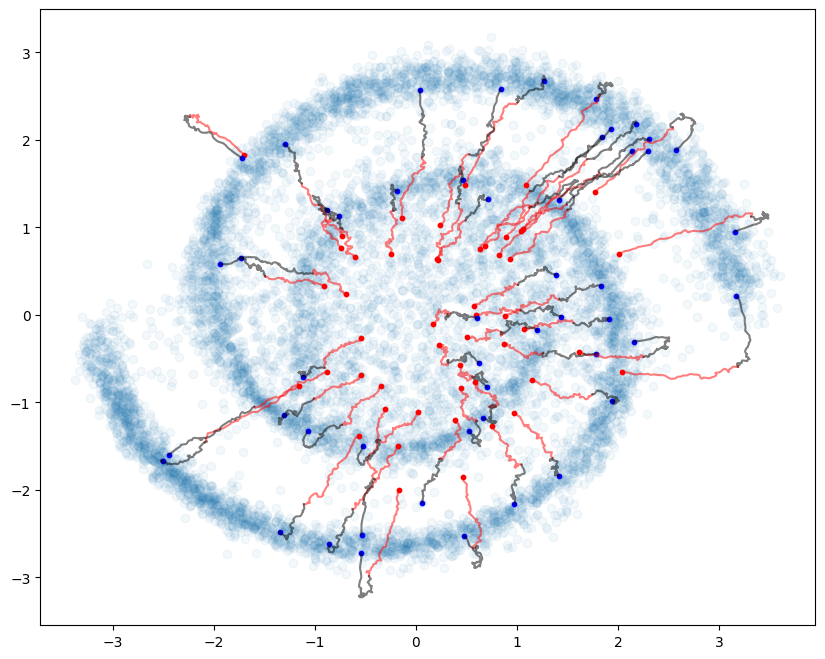

In [42]:
num_trajectories = 50

time_points = np.linspace(0,0.5,100)
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.05)

path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c = 'red',alpha = 0.5)

time_points = np.linspace(0.5,1.,100)
path = jnp.array([sol.evaluate(t)[:num_trajectories] for t in time_points])
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1],c='black',alpha = 0.5)

plt.scatter(X0[:num_trajectories,0],X0[:num_trajectories,1],c = 'red',s = 10.)

plt.scatter(X[:num_trajectories,0],X[:num_trajectories,1],c = 'blue',s = 10.)
plt.show()

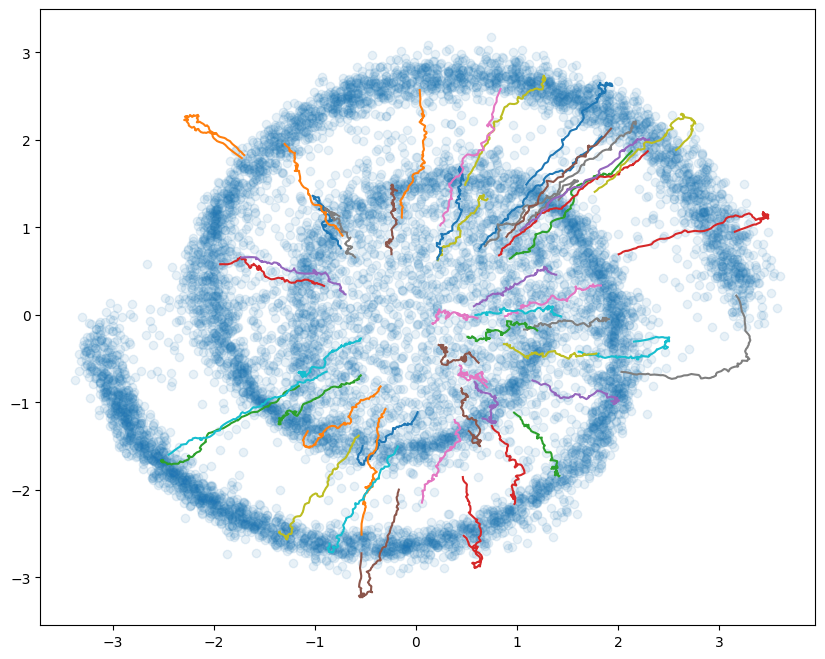

In [44]:
time_points = np.linspace(0,1,100)

path = jnp.array([sol.evaluate(t)[:50] for t in time_points])
plt.figure(figsize=(10,8))
plt.scatter(X[:,0],X[:,1],alpha = 0.1)
for i in range(len(path[0])):
    plt.plot(path[:,i,0],path[:,i,1])

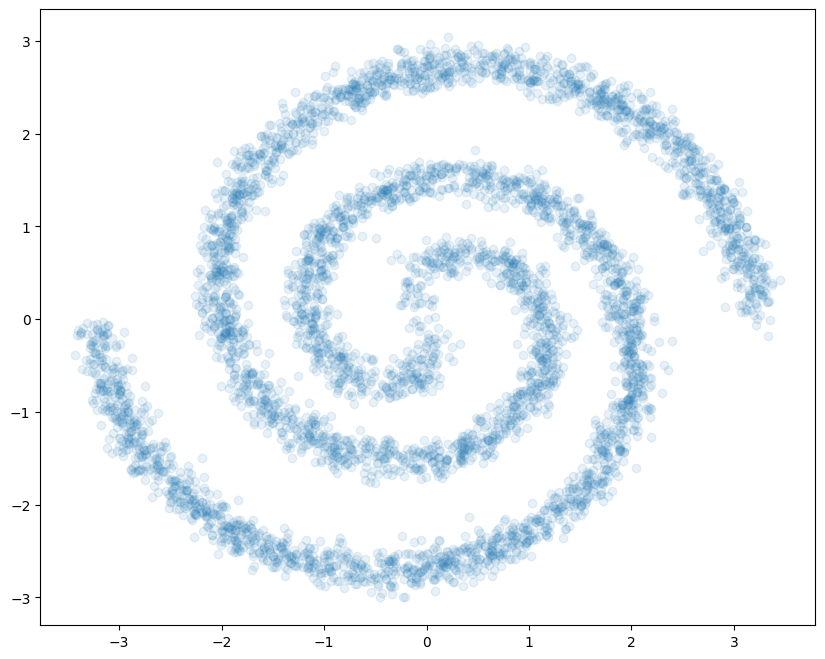

In [9]:
plt.figure(figsize=(10,8))
plt.scatter(target_samples[:,0],target_samples[:,1],alpha = 0.1)
